In [1]:
# Import libraries for data analysis    
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1. Exploratory Data Analysis

In [39]:
# import csv dataset in pandas and display the first 5 rows
df = pd.read_csv('./NCDataChallenge_2021_v1.csv', delimiter=',', index_col=0)


* Convert the outcome and regular_cycle rows from bool to zeros and ones

In [40]:
# print the unique values in the outcome column
print(df['outcome'].unique())

# Convert outcome column to binary

df['outcome'] = df['outcome'].replace(['pregnant', 'not_pregnant'], [1, 0])
df = df.dropna(subset=['regular_cycle'])
df['regular_cycle'] = df['regular_cycle'].replace([True, False], [1, 0])


['pregnant' 'not_pregnant']


C:\Users\vbencini\AppData\Local\Temp\ipykernel_14400\1254878092.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['outcome'] = df['outcome'].replace(['pregnant', 'not_pregnant'], [1, 0])
C:\Users\vbencini\AppData\Local\Temp\ipykernel_14400\1254878092.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['regular_cycle'] = df['regular_cycle'].replace([True, False], [1, 0])


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1989 entries, 0 to 2000
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bmi                    1989 non-null   float64
 1   age                    1989 non-null   int64  
 2   country                1876 non-null   object 
 3   been_pregnant_before   1674 non-null   object 
 4   education              1601 non-null   object 
 5   sleeping_pattern       1495 non-null   object 
 6   n_cycles_trying        1989 non-null   int64  
 7   outcome                1989 non-null   int64  
 8   dedication             1989 non-null   float64
 9   average_cycle_length   1989 non-null   float64
 10  cycle_length_std       1970 non-null   float64
 11  regular_cycle          1989 non-null   int64  
 12  intercourse_frequency  1989 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 217.5+ KB


#### Numerical variables

In [42]:
sns.pairplot(df)

Looking at the pairplot we can observe that:
* average_cycle_length and the cycle_length_std have outliers
* bmi has some values set to zero

Let's start removing the ouliers. We remove all the values that are not included in the interval $\mu \pm 3\sigma$

In [43]:
# Let's remove the outliers from the average_cycle_length column. Cycles longer than 40 days can be consiered anomalies. 

df['average_cycle_length'] = df['average_cycle_length'].fillna(df['average_cycle_length'].mean()) 

df['average_cycle_length'].std()*3
df['average_cycle_length'].mean()

# cut the values which are higher than mean+3*std or lower than -3*std
df = df[(df['average_cycle_length'] < df['average_cycle_length'].mean() + 3*df['average_cycle_length'].std()) & (df['average_cycle_length'] > df['average_cycle_length'].mean() - 3*df['average_cycle_length'].std())]


# df = df.dropna(subset=['average_cycle_length'])


For the cycle_length_std and average we notice that there are missing values. To impute the missing values we use the mean of the column 

In [44]:
# inpute the missing values in cycle_length_std column with the mean value
df['cycle_length_std'] = df['cycle_length_std'].fillna(df['cycle_length_std'].mean()) 

df['cycle_length_std'].std()*3
df['cycle_length_std'].mean()

# cut the values which are higher than mean+3*std or lower than -3*std
df = df[(df['cycle_length_std'] < df['cycle_length_std'].mean() + 3*df['cycle_length_std'].std()) & (df['cycle_length_std'] > df['cycle_length_std'].mean() - 3*df['cycle_length_std'].std())]


<Axes: xlabel='cycle_length_std'>

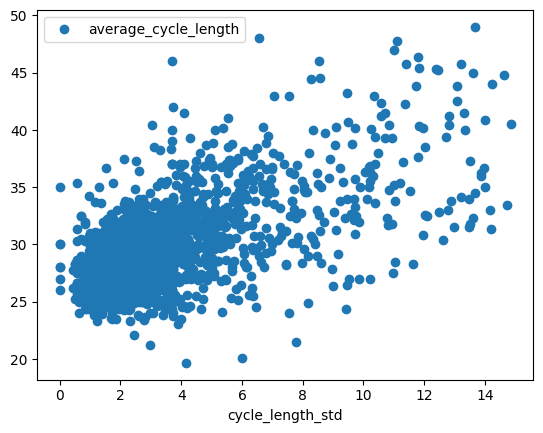

In [45]:
df.plot(x='cycle_length_std', y='average_cycle_length', style='o')

And we replace the zero values in bmi with the mean



In [46]:
df['bmi'].replace(0,df['bmi'].mean(), inplace=True)

C:\Users\vbencini\AppData\Local\Temp\ipykernel_14400\4088759818.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].replace(0,df['bmi'].mean(), inplace=True)


#### Categorical variables

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 0 to 2000
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bmi                    1917 non-null   float64
 1   age                    1917 non-null   int64  
 2   country                1804 non-null   object 
 3   been_pregnant_before   1606 non-null   object 
 4   education              1537 non-null   object 
 5   sleeping_pattern       1437 non-null   object 
 6   n_cycles_trying        1917 non-null   int64  
 7   outcome                1917 non-null   int64  
 8   dedication             1917 non-null   float64
 9   average_cycle_length   1917 non-null   float64
 10  cycle_length_std       1917 non-null   float64
 11  regular_cycle          1917 non-null   int64  
 12  intercourse_frequency  1917 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 209.7+ KB


For the country variable, it does make sense to inpute the most frequent value, so we simply create a new category 'NS' standing for non specified

In [48]:
# Replace the null values in country and been_pregnant_before with 'NS' parameter
df['country'] = df['country'].fillna('NS')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 0 to 2000
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bmi                    1917 non-null   float64
 1   age                    1917 non-null   int64  
 2   country                1917 non-null   object 
 3   been_pregnant_before   1606 non-null   object 
 4   education              1537 non-null   object 
 5   sleeping_pattern       1437 non-null   object 
 6   n_cycles_trying        1917 non-null   int64  
 7   outcome                1917 non-null   int64  
 8   dedication             1917 non-null   float64
 9   average_cycle_length   1917 non-null   float64
 10  cycle_length_std       1917 non-null   float64
 11  regular_cycle          1917 non-null   int64  
 12  intercourse_frequency  1917 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 209.7+ KB


For the been_pregnant_before variable we are interested in a yes/no answer more than how many times it happened. 
* Assing 1 if the woman was pregnant beofre and 0 if she was not
* Inpute 0 if the answer was not given

In [51]:
df['been_pregnant_before'] = df['been_pregnant_before'].fillna('NS')
df['been_pregnant_before'] = df['been_pregnant_before'].apply(lambda x: 1 if 'Yes' in x else 0)




We use the same apporach to sleeping patter, where we assing 1 if the sleeping patter in regular and 0 if it is not. As for inputation, we assign the most frequent value


In [54]:
# Let's check the frequnecy of each unique value in the sleeping_pattern column
df['sleeping_pattern'].value_counts()

sleeping_pattern
Wake same every workday           778
Several times during the night    240
Wake same every day               208
Shift worker                      140
Late and snoozer                   71
Name: count, dtype: int64

In [55]:
# Let's replace the null values in the sleeping_pattern column with the most frequent value
df['sleeping_pattern'] = df['sleeping_pattern'].fillna('Wake same every workday')

# The sleeping patter can be split into two categories: regular or not regular. Let's create a new column 'regular_sleeping_pattern' which will be 1 if the sleeping pattern is regular and 0 if it is not regular
df['regular_sleeping_pattern'] = df['sleeping_pattern'].apply(lambda x: 1 if 'same' in x else 0)
df.drop('sleeping_pattern', axis=1, inplace=True)

# convert regualr cycles from bool to 1 and 0
df['regular_cycle'] = df['regular_cycle'].replace([True, False], [1, 0])

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 0 to 2000
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bmi                       1917 non-null   float64
 1   age                       1917 non-null   int64  
 2   country                   1917 non-null   object 
 3   been_pregnant_before      1917 non-null   int64  
 4   education                 1537 non-null   object 
 5   n_cycles_trying           1917 non-null   int64  
 6   outcome                   1917 non-null   int64  
 7   dedication                1917 non-null   float64
 8   average_cycle_length      1917 non-null   float64
 9   cycle_length_std          1917 non-null   float64
 10  regular_cycle             1917 non-null   int64  
 11  intercourse_frequency     1917 non-null   float64
 12  regular_sleeping_pattern  1917 non-null   int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 209.7+ KB


Also for education, we assign the most frequent value to missing values

In [60]:
df['education'].value_counts()

education
University                             1044
PhD                                     178
High school                             161
Trade/technical/vocational training     140
Elementary school                        14
Name: count, dtype: int64

In [61]:
df['education'] = df['education'].fillna('University')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 0 to 2000
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bmi                       1917 non-null   float64
 1   age                       1917 non-null   int64  
 2   country                   1917 non-null   object 
 3   been_pregnant_before      1917 non-null   int64  
 4   education                 1917 non-null   object 
 5   n_cycles_trying           1917 non-null   int64  
 6   outcome                   1917 non-null   int64  
 7   dedication                1917 non-null   float64
 8   average_cycle_length      1917 non-null   float64
 9   cycle_length_std          1917 non-null   float64
 10  regular_cycle             1917 non-null   int64  
 11  intercourse_frequency     1917 non-null   float64
 12  regular_sleeping_pattern  1917 non-null   int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 209.7+ KB


Let's plot the cleaned data to check that everything looks fine

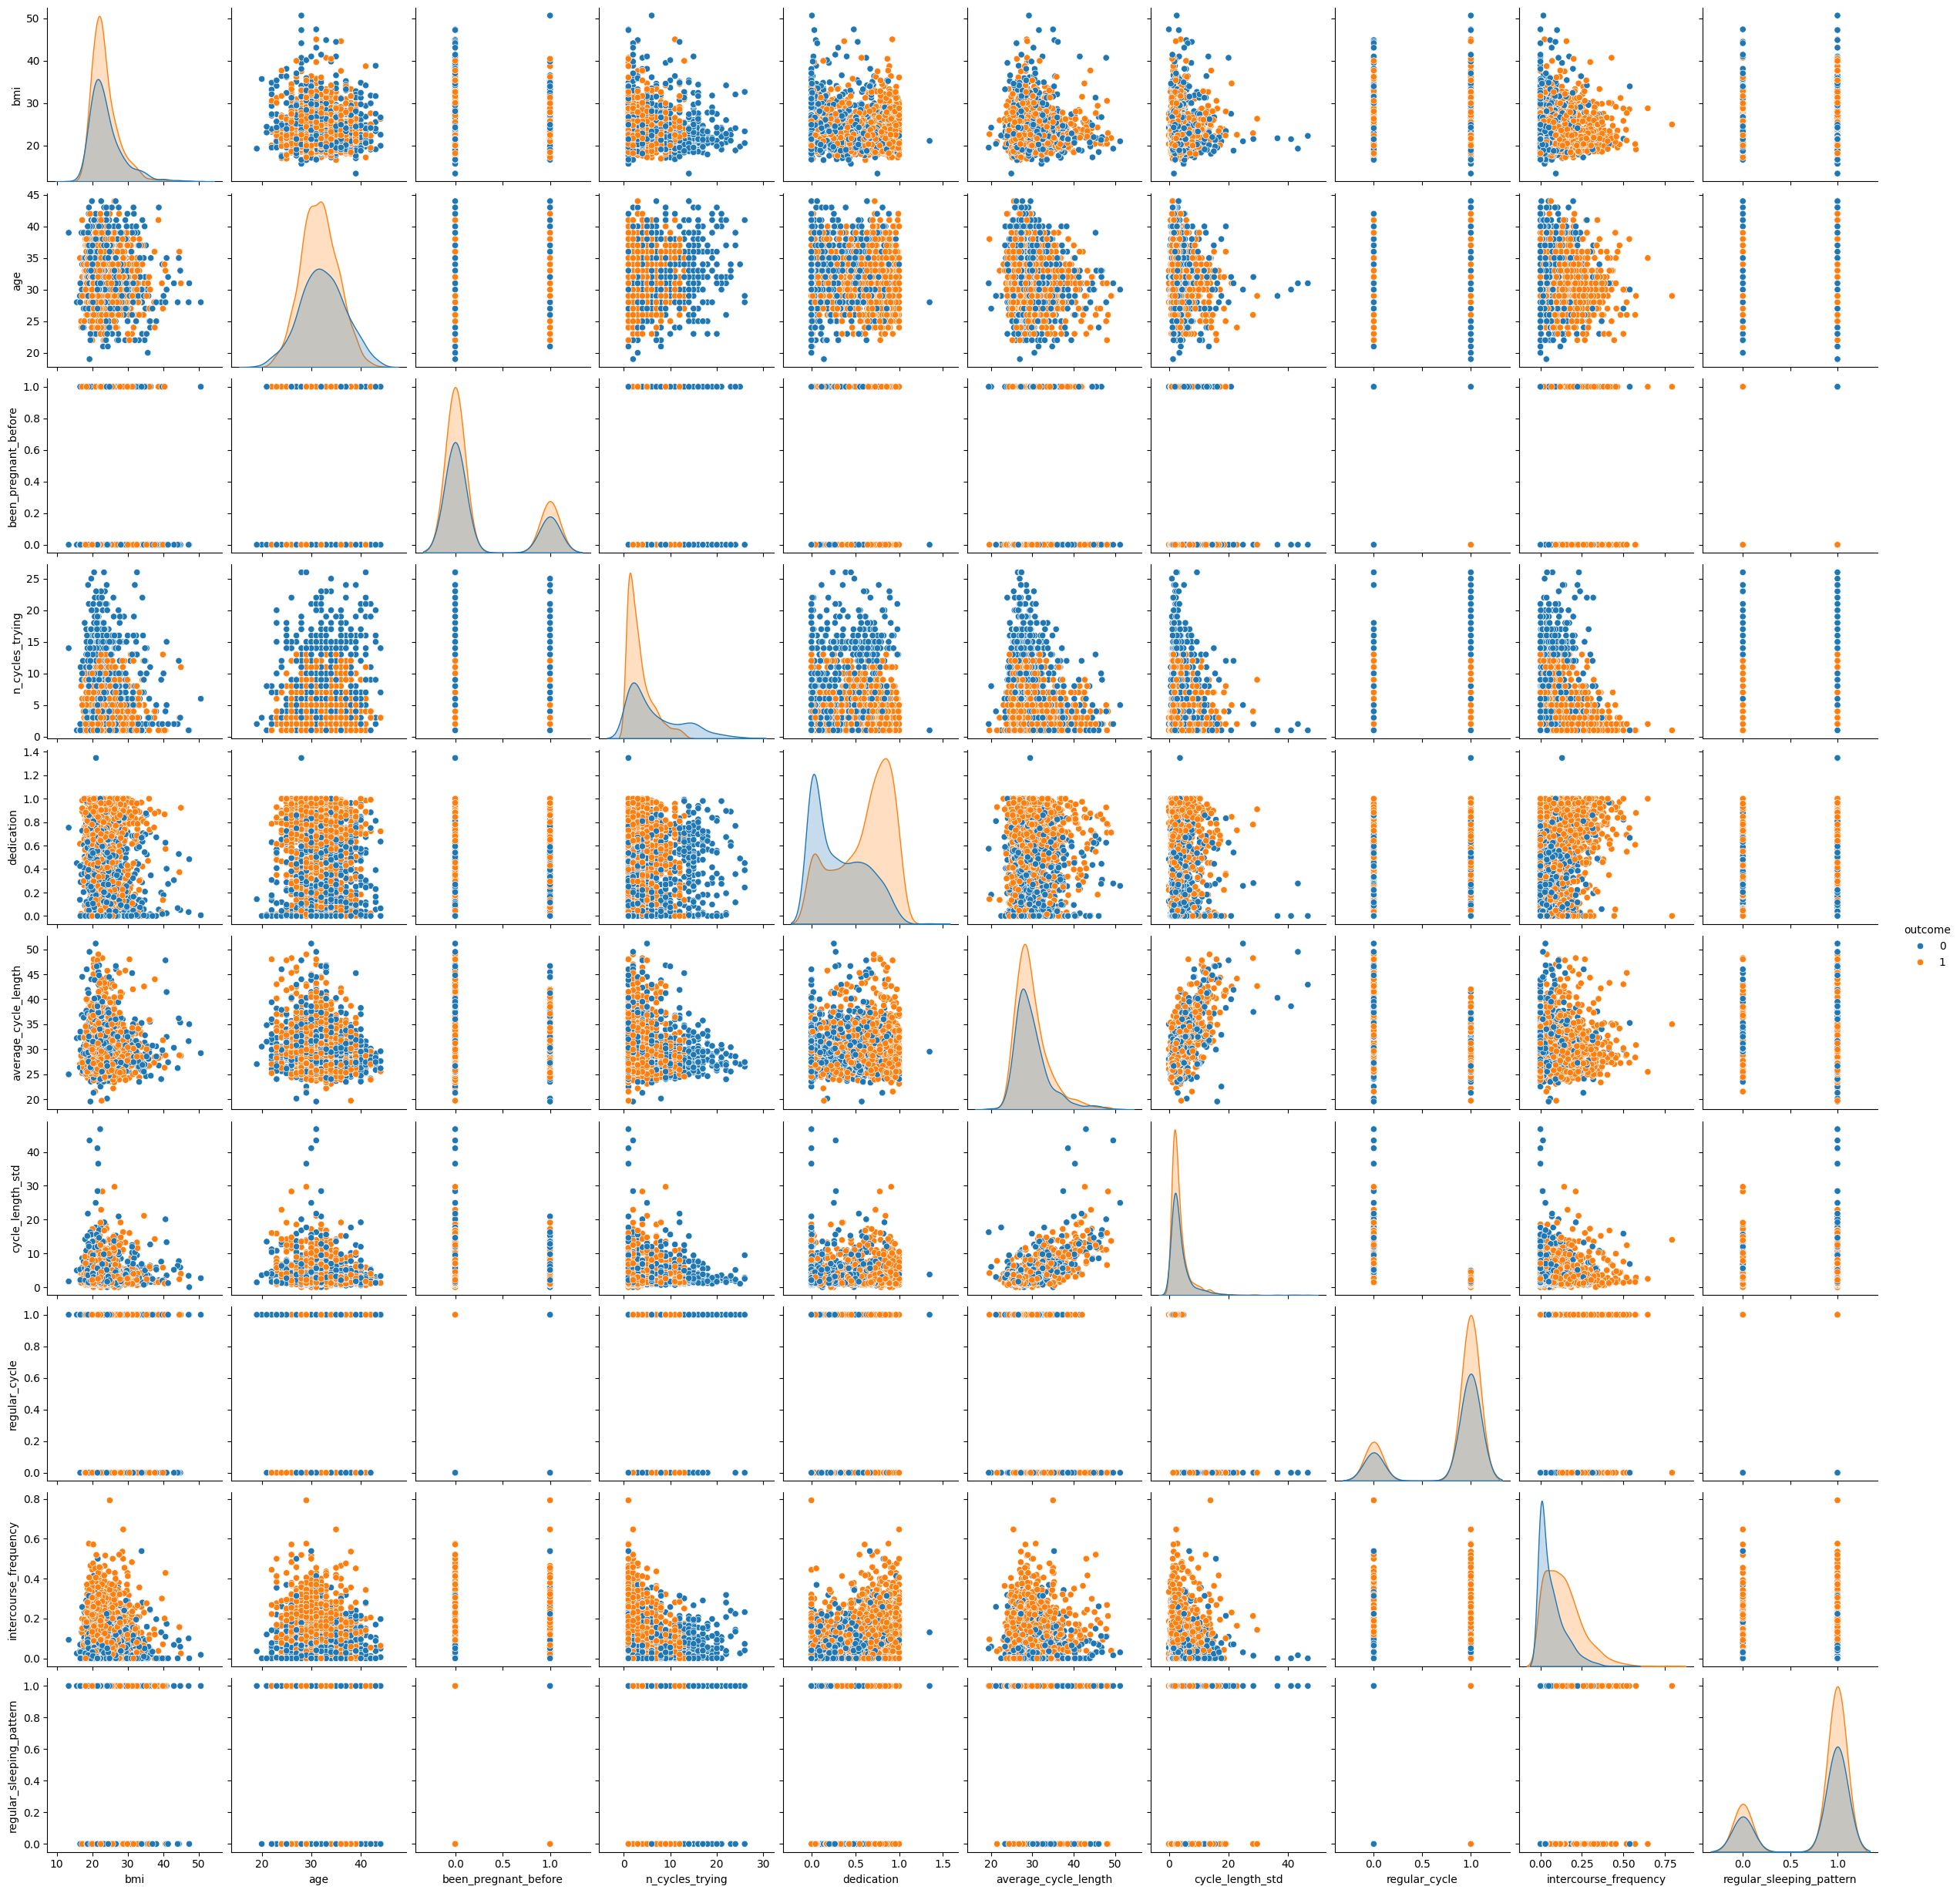

In [15]:
sns.pairplot(df, hue='outcome')

## 2 Probability of getting pregnant within 13 cycles




## 2.1 Bayes approach

#### Assumptions

1. Here we consider the provided data to be representative of the population. The probability of getting pregnant is therefore calculated as ratio between successful pregnancy over total number of women on the dataset. 

#### 

To calculate the probaibility of getting pregnant within 13 cycles we use Bayes rule. In particular we consider the two events of interest:

A = Getting pregnant \
B = Number of cycles trying <= 13

We want to calculate:

$ P(A|B) = \frac{P(A)P(B|A)}{P(B)}$

Where

$ P(B|A) = \frac{P(A,B)}{P(A)} $

<Axes: xlabel='n_cycles_trying', ylabel='Count'>

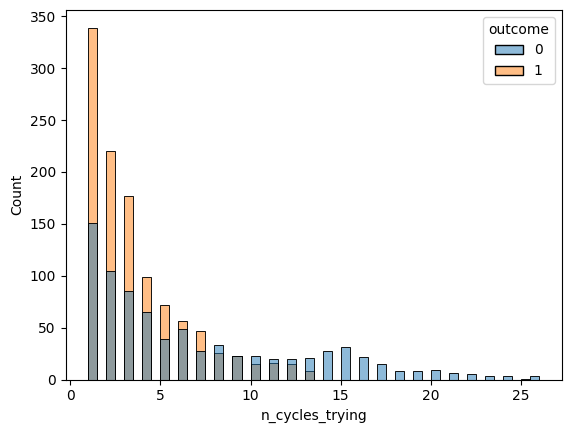

In [63]:
# plot the distribution of the number of cycles trying for each value of outcome
plt.figure()
sns.histplot(data=df, x='n_cycles_trying', hue='outcome', bins=50)

In [64]:

# calculate the ration of values of outcome ==1 to the total number of values in the outcome column

# Probability of getting pregnant:
# This is the number of women who got pregnant divided by the size of the sample population
p_a = df['outcome'].value_counts(normalize=True).loc[1]
print(f"P(A) = {p_a}")

# Probability of n_cycles_trying <=13
# This is the number of women trying for less then 13 cycles divided by size of the sample population
p_b = df[df['n_cycles_trying'] <= 13].shape[0] / df.shape[0]
print(f"P(B) = {p_b}")

# Probability of n_cycles trying<=13 given outome=1
# This is the number of n_cycles_trying <=13 given outcome=1 divided by the number
df_temp = df[df['outcome'] == 1]
df_temp = df_temp[df_temp['n_cycles_trying'] <= 13]
p_a_join_b = df_temp.shape[0] / df.shape[0]
p_b_a = p_a_join_b / p_a
print(f"P(B|A) = {p_b_a}")


p_a_b = (p_a * p_b_a) / p_b

p_a_b


P(A) = 0.5805946791862285
P(B) = 0.9259259259259259
P(B|A) = 1.0


0.6270422535211269

The Bayes appraoch provide a first estimate of the probaiblity of getting pregnant within 13 cycles. However, the result is including also women who stopped to try to get pregnant or using the app. This meand that the probability of gettin pregnant is underestimated. 

## 2.2 Surviaval analysis appraoch

In order to account for the the women who dropped the study before the 13th week we use the survival analysis approach. In particular we use the Kaplan Meier Estimator, which allowes to consider censored data in the analysis, providng a more accurate estimte of the probablity of getting pregnant. 

In [70]:
from lifelines import KaplanMeierFitter

data = df.copy()
# Create a new column indicating if the data is censored


# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=data['n_cycles_trying'], event_observed=data['outcome'])

# Transform the survival function to get the cumulative incidence function
survival_function = 1-kmf.survival_function_
survival_confidence_intervals = 1-kmf.confidence_interval_survival_function_

cumulative_incidence_function = survival_function
cumulative_incidence_confidence_intervals = survival_confidence_intervals







# Calculate the probability of getting pregnant within 13 cycles
probability_pregnant_within_13_cycles = cumulative_incidence_function.loc[13, 'KM_estimate']
probability_pregnant_within_13_cycles


0.7477586137872586

As expected, the probability obtained with the Kaplan-Meier Estimator is higher.

**Results**

1. Bayesian estimate:

    P(A|B) = 62.4 %

2. Kaplan Meier Estimator:

    P(A|B) = 74.8 % (CI: 72.1-77.3)


### 3 Time to pregnancy average value



### 3.1 Survival analysis approach
To calculate the usual time to pregnancy we can use the results from the Kaplan Meier analysis. In particular we are looking for the number of cycles corresponding to a cumulative probability of 50%

In [66]:
# Compute the median of the output of the kaplan meier estimate
median = kmf.median_survival_time_
median

5.0

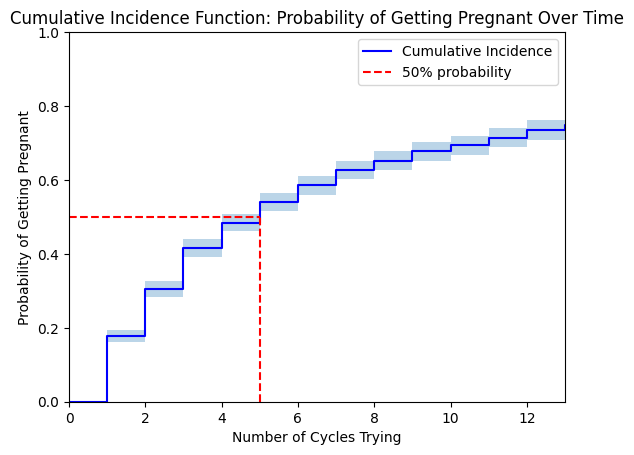

In [71]:
# Plot the cumulative incidence function with confidence intervals
plt.figure()
plt.step(cumulative_incidence_function.index, cumulative_incidence_function['KM_estimate'], where="post", label='Cumulative Incidence', color='blue')
plt.fill_between(cumulative_incidence_confidence_intervals.index,
                 cumulative_incidence_confidence_intervals['KM_estimate_lower_0.95'],
                 cumulative_incidence_confidence_intervals['KM_estimate_upper_0.95'],
                 step="post", alpha=0.3)
# add an horizontal line at y=0.5 with a range between 0 and the corresponding x value
plt.hlines(0.5, 0, 5, colors='r', linestyles='dashed', label='50% probability')

# add a vertical line the corresponding x value
plt.vlines(5, 0, 0.5, colors='r', linestyles='dashed')


plt.title('Cumulative Incidence Function: Probability of Getting Pregnant Over Time')
plt.xlabel('Number of Cycles Trying')
plt.ylabel('Probability of Getting Pregnant')
plt.ylim(0, 1)
plt.xlim(0, 13)
plt.legend()
# plt.grid(True)
plt.show()

To get the avergae time to pregnancy in days, we also have to include the different cycle length for each woman and its variability. 

1. Since in the dataset only a mean and a standard deviation are provided, we assume that the variability id normally distributed around the mean.
2. We do not make any assumption about the distribution of the average_cycle_length varibale. From EDA we see that it is not symmetric and not gaussian. 

To estimate the average number of days to pregnancy we use a monte Carlo simulation approach. We generate multiple datasets sampling from a distribution with mean= average_cycle_length and std = cycle_length_std. To each simulated dataset we apply the Kaplan Meier estimator and calculate the median survival time.

We than calculate the mean and standard deviation of the resulting data.

In [ ]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Load the dataset


df_temp = df.copy()
# Calculate the mean and standard deviation of time in days for each woman
df_temp['mean_days_to_pregnancy'] = df_temp['n_cycles_trying'] * df_temp['average_cycle_length']
df_temp['days_variability'] = df_temp['n_cycles_trying'] * df_temp['cycle_length_std']

# Number of simulations
n_simulations = 1000

# Store the results of each simulation
survival_functions = []
m_time = []
days = np.arange(1500)
for _ in range(n_simulations):
    # Generate a simulated dataset
    simulated_days = np.random.normal(loc=df_temp['mean_days_to_pregnancy'], 
                                      scale=df_temp['days_variability'])
    
    # Create a new DataFrame for Kaplan-Meier fitting
    simulated_df = pd.DataFrame({
        'days_to_pregnancy': simulated_days,
        'outcome': df['outcome']
    })
    
    # Fit the Kaplan-Meier model
    kmf = KaplanMeierFitter()
    kmf.fit(durations=simulated_df['days_to_pregnancy'], event_observed=simulated_df['outcome'])
    if kmf.survival_function_.index[0]<0:
        continue

    # interpolate the survival function with a step of 1 day
    kmf.survival_function_ = kmf.survival_function_.reindex(days, method='nearest').interpolate()

    m_time.append(kmf.median_survival_time_)
    # Store the survival function
    # plt.plot(kmf.survival_function_, color='blue')
    survival_functions.append(kmf.survival_function_['KM_estimate'])



# Combine the results to get a mean survival function and confidence intervals
# survival_df = pd.concat(survival_functions, axis=1)
# mean_survival_function = survival_df.mean(axis=1)
# lower_bound = survival_df.quantile(0.025, axis=1)
# upper_bound = survival_df.quantile(0.975, axis=1)




(0.0, 1500.0)

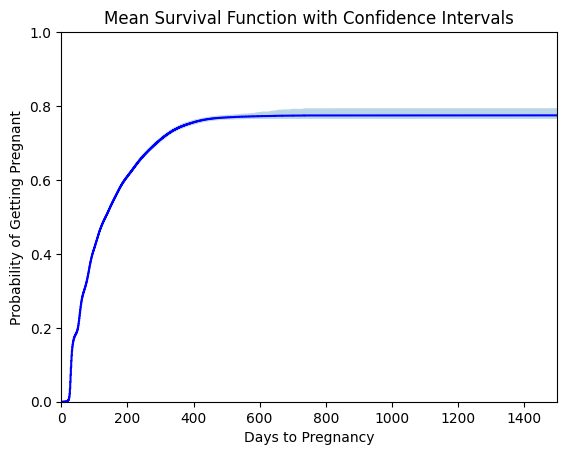

In [125]:
survival_array = 1-np.array(survival_functions)
mean_survival_function = np.mean(survival_array, axis=0)
lower_bound = np.quantile(survival_array, 0.025, axis=0)
upper_bound = np.quantile(survival_array, 0.975, axis=0)



In [126]:
m_time = np.array(m_time)
print(f"Mean median survival time: {m_time.mean()}")
print(f"Standard deviation of median survival time: {m_time.std()}")

Mean median survival time: 133.67143134124782
Standard deviation of median survival time: 1.7989837488628226


(0.0, 1500.0)

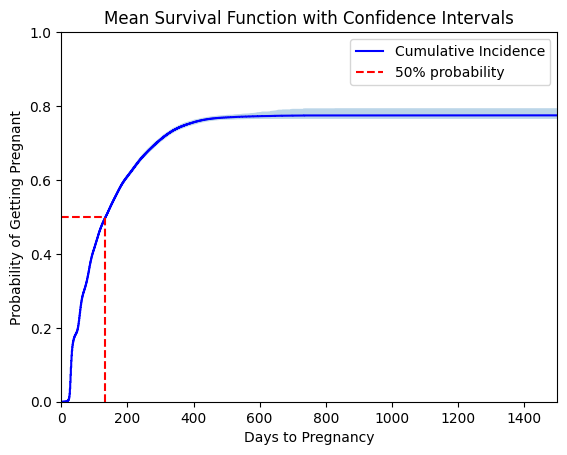

In [129]:
# plot the mean survival function with confidence intervals
plt.figure()
plt.step(days, mean_survival_function, where="post", label='Cumulative Incidence', color='blue')
plt.fill_between(days, lower_bound, upper_bound, step="post", alpha=0.3)

# add an horizontal line at y=0.5 with a range between 0 and the corresponding x value
plt.hlines(0.5, 0, m_time.mean(), colors='r', linestyles='dashed', label='50% probability')

# add a vertical line the corresponding x value
plt.vlines(m_time.mean(), 0, 0.5, colors='r', linestyles='dashed')
plt.title('Mean Survival Function with Confidence Intervals')
plt.xlabel('Days to Pregnancy')
plt.ylabel('Probability of Getting Pregnant')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 1500)

In [134]:
del survival_functions

## 4. Factors influencing the time-to-pregnancy



### 4.1 Kaplan-Meier on fractions of dataset

A good approach to calculate the the effect on the time to get pregnant is to ananlyse the effect of selecting sub-categories of a given variable on the median survival time. For example if we consider the age, we can split the age into 4 categories and for each one compute the survival curve.

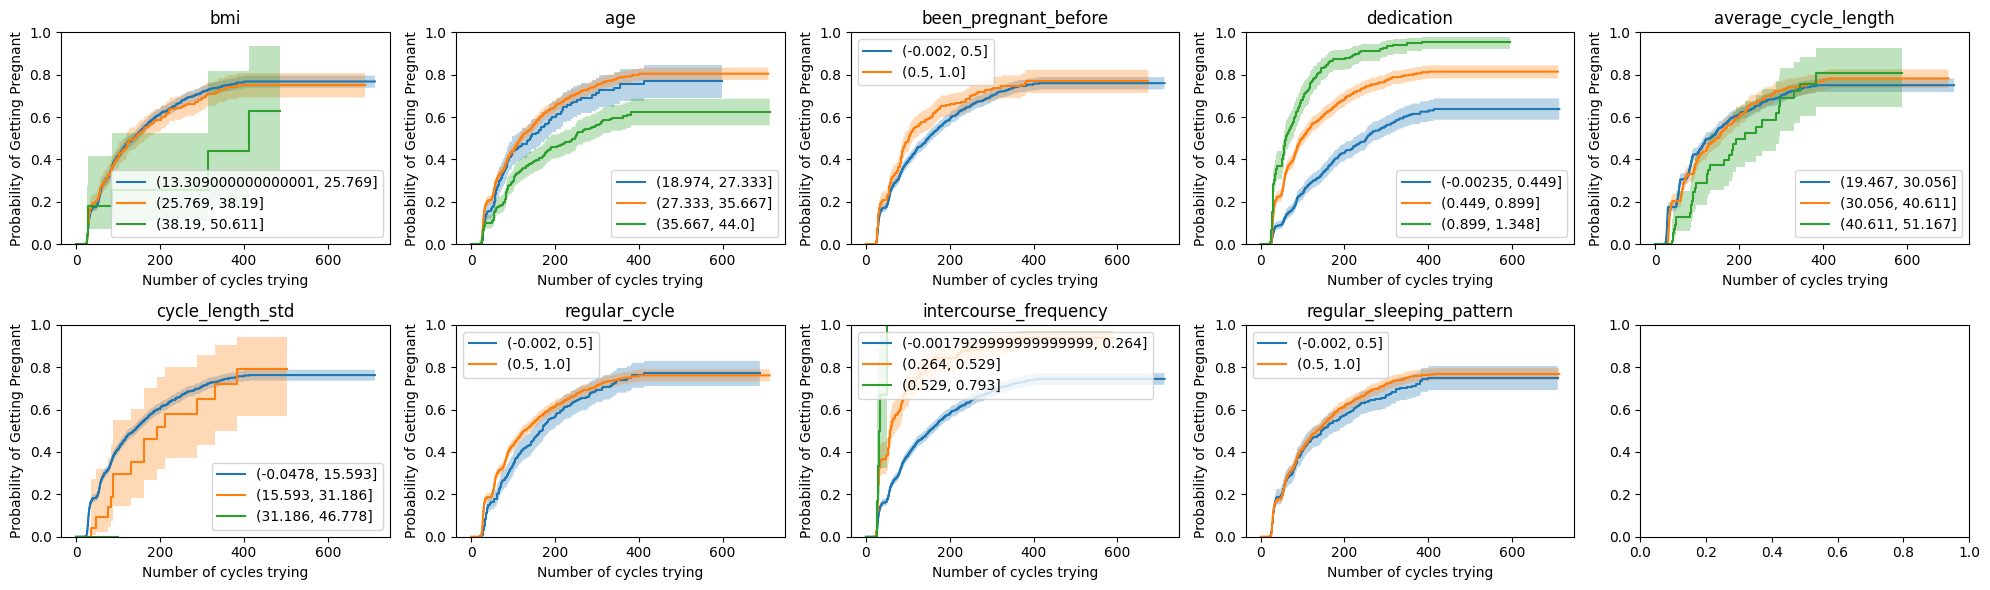

In [29]:

def plot_survival_function(mean_survival_function, confidence_intervals, label, variable, ax):
    
    ax.step(mean_survival_function.index, mean_survival_function['KM_estimate'], where="post", label=label)
    ax.fill_between(mean_survival_function.index, confidence_intervals['KM_estimate_lower_0.95'], confidence_intervals['KM_estimate_upper_0.95'], step="post", alpha=0.3)
    ax.set_title(f'{variable}')
    ax.set_ylabel('Probability of Getting Pregnant')
    ax.set_xlabel('Number of cycles trying')
    ax.set_ylim(0, 1)







data_time = df.copy()
data_time['days_to_pregnancy'] = data_time['n_cycles_trying'] * data_time['average_cycle_length']

# data_time = data_time[data_time['outcome'] == 1]
def calculate_median_survival(df, variable, axs, bins=3):
    if df[variable].value_counts().shape[0] < bins:
        df['category'] = pd.cut(df[variable], bins=2, include_lowest=True)
    else:
        df['category'] = pd.cut(df[variable], bins=bins, include_lowest=True)
    # df['category'] = pd.qcut(df[variable], q=bins)
    kmf = KaplanMeierFitter()
    median_survival_times = []
    categories = df['category'].cat.categories
    
    
    for category in categories:
        mask = df['category'] == category
        kmf.fit(durations=df[mask]['days_to_pregnancy'], event_observed=df[mask]['outcome'])
        survival_function = 1-kmf.survival_function_
        survival_confidence_intervals = 1-kmf.confidence_interval_survival_function_

        cumulative_incidence_function = survival_function
        cumulative_incidence_confidence_intervals = survival_confidence_intervals
        plot_survival_function(cumulative_incidence_function, cumulative_incidence_confidence_intervals, category, variable, axs)
        median_survival_times.append((category, kmf.median_survival_time_))
        # plt.axhline(y=0.5, color='r', linestyle='--')
        # plt.axvline(x=kmf.median_survival_time_, color='r', linestyle='--')
    
        

    return pd.DataFrame(median_survival_times, columns=['Category', 'MedianSurvivalTime'])



# Calculate median survival times
# age_survival_df = calculate_median_survival(df, 'age')
# bmi_survival_df = calculate_median_survival(df, 'bmi')
# cycle_length_survival_df = calculate_median_survival(df, 'average_cycle_length')

# been_pregnant_before_df = calculate_median_survival(df, 'been_pregnant_before')
# dedication_df = calculate_median_survival(df, 'dedication')
# intercourse_frequency_df = calculate_median_survival(df, 'intercourse_frequency')
columns = ['bmi', 'age', 'been_pregnant_before', 'dedication',
       'average_cycle_length', 'cycle_length_std', 'regular_cycle',
       'intercourse_frequency', 'regular_sleeping_pattern']
fig, axs = plt.subplots(2, 5, figsize=(20, 6))
axs = axs.flatten() 
for ind, p in enumerate(columns):
    
    calculate_median_survival(data_time, p, axs[ind])
    axs[ind].legend()
plt.tight_layout()

With this apporach we can see that the parameters with the highest impact are:
1. intercourse frequency
2. dedication
3. Been pregnant before
3. age (when above 35 years old)

### 4.2 Cox proportional hazard model

The cox proportional hazard model allows to find how each variable influences the probability of getting pregnant in a more sistematic way. The model is semi-parametric and assumes an exponential function as sruvival curve. The impact of a variable on the output is caluclated comapring the slope of the log survival curve. 

In [139]:
from lifelines import CoxPHFitter
data_time_cox = df.copy()
data_time_cox['days_to_pregnancy'] = data_time_cox['n_cycles_trying'] * data_time_cox['average_cycle_length']
# Fit the Cox model

numerical_features = ['bmi', 'age', 'been_pregnant_before','days_to_pregnancy'
       , 'outcome', 'dedication', 'average_cycle_length',
       'cycle_length_std', 'regular_cycle', 'intercourse_frequency',
       'regular_sleeping_pattern']

cph = CoxPHFitter()
cph.fit(data_time_cox[numerical_features], duration_col='days_to_pregnancy', event_col='outcome')

# Print the summary to get the coefficients
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1917 total observations, 804 right-censored observations>
             duration col = 'days_to_pregnancy'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 1917
number of events observed = 1113
   partial log-likelihood = -7435.30
         time fit was run = 2024-05-17 12:12:45 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
bmi                      -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                      -0.04      0.96      0.01           -0.06           -0.03                0.94                0.97
been_pregnant_before      0.36      1.43      0.07            0.21            0.50                1.24                1.65
dedication                1.23      3.44      0.11            1.01            1.45                2.76                4.28
average_cycle_length     -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
cycle_length_std         -0.05      0.95      0.02           -0.10           -0.01                0.91                0.99
regular_cycle            -0.05      0.95      0.14           -0.32            0.23                0.72                1.25
intercourse_frequency     2.58     13.18      0.30            1.98            3.17                7.27               23.87
regular_sleeping_pattern  0.08      1.08      0.07           -0.06            0.22                0.94                1.25

                          cmp to     z      p  -log2(p)
covariate                                              
bmi                         0.00 -0.56   0.57      0.80
age                         0.00 -5.37 <0.005     23.58
been_pregnant_before        0.00  4.83 <0.005     19.45
dedication                  0.00 11.03 <0.005     91.50
average_cycle_length        0.00 -0.64   0.52      0.94
cycle_length_std            0.00 -2.22   0.03      5.24
regular_cycle               0.00 -0.35   0.73      0.46
intercourse_frequency       0.00  8.50 <0.005     55.59
regular_sleeping_pattern    0.00  1.11   0.27      1.91
---
Concordance = 0.68
Partial AIC = 14888.60
log-likelihood ratio test = 388.76 on 9 df
-log2(p) of ll-ratio test = 257.33

<Axes: xlabel='log(HR) (95% CI)'>

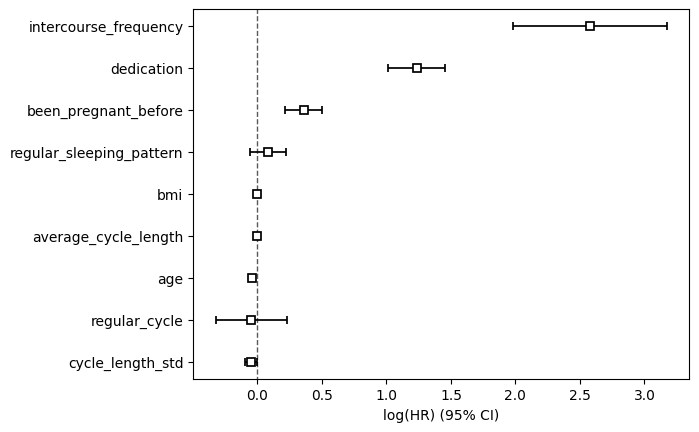

In [140]:
cph.plot()

In [142]:
cph.score(data_time_cox[numerical_features])

-3.8786122613099083

### 4.3 Random Survival Forest

A way to include the influence of all variables on the outcome and excluding any assumption about the survival function is to use an ML approach. In particular we can use Random Survival Forest algortihm

In [131]:
import pandas as pd
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler

data_rsf = df.copy()

data_rsf['days_to_pregnancy'] = data_rsf['n_cycles_trying'] * data_rsf['average_cycle_length']
# Fit the Cox model

numerical_features = ['bmi', 'age', 'been_pregnant_before','days_to_pregnancy'
       , 'outcome', 'dedication', 'average_cycle_length',
       'cycle_length_std', 'regular_cycle', 'intercourse_frequency',
       'regular_sleeping_pattern']
# Convert the outcome and duration to a structured array
y = Surv.from_arrays(event=data_rsf['outcome'].astype(bool), time=data_rsf['days_to_pregnancy'])

# Select features


# Standardize the features
X = data_rsf[numerical_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [132]:
from sksurv.ensemble import RandomSurvivalForest

# Initialize and fit the Random Survival Forest model
rsf = rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
)
rsf.fit(X_scaled, y)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=42)

In [133]:
rsf.score(X_scaled, y)

0.9598321836883336

The score is very high, meaning that the model is able to predict the survival function with high accuracy. Let's plot the survival function and the cumulative incidence function for the Random Survival Forest model.

In [135]:

from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_scaled, y, n_repeats=15, random_state=42)


In [137]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
outcome,0.219823,0.008187
days_to_pregnancy,0.190156,0.006520
cycle_length_std,0.006050,0.001194
intercourse_frequency,0.004148,0.000846
dedication,0.003765,0.000642
age,0.003553,0.000537
average_cycle_length,0.002638,0.000297
been_pregnant_before,0.002349,0.000383
bmi,0.001765,0.000223
regular_sleeping_pattern,0.000225,0.000106
